In [146]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

# scikit-learn

Scikit-Learn is one of the most widely used python modules for machine learning. It has implementations of a huge number of algorithms and helper tools and (as far as possible) provides a consistent and easy to use interface to them. 

_**Caveat**: Machine learning is a _huge_ topic and I'm not an expert in it. These notes cover some introductory steps and useful tips, but you should augment them with other resources as you learn more. The [scikit-learn tutorial](https://scikit-learn.org/stable/tutorial/index.html) is a good place to start, and there are lots of [courses](https://medium.com/javarevisited/5-best-scikit-learn-online-courses-for-machine-learning-and-data-science-6beb02e9cca0) and [books](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?keywords=hands-on+machine+learning+with+scikit-learn%2C+keras%2C+and+tensorflow&qid=1657479285&sprefix=scikit-learn%2Caps%2C425&sr=8-1) available._

## The Problem

Machine Learning problems usually start with a (potentially large) collection of data which you want to use to draw inferences from to make predictions. There are two broad categories of machine learning algorithms:

  * **Supervised Learning**: In supervised learning, the data you are learning from comes with the answers: it is _labeled_. The idea is to use this labeling to train your algorithm to make predictions for new data which lack the labels. There are two broad categories of problem where supervised learning is used:
  
      * **Classification Problems**: where you want to use the data to divide instances into discrete categories (e.g. Logistic Regression)
      * **Regression Problems**: where you want to use the data to make some numerical predictions (e.g. Linear Regression)
      
      
  * **Unsupervised Learning**: In unsupervised learning the learning algorithm has to learn for itself. It has no labels to guide it, only the data. Some of the most common categories or problem tackled with unsupervised learning algorithms are:
      * **Clustering**: Recognizing distinct groups within the data (e.g. K-Means)
      * **Dimensionality Reduction** Making datasets more tractable while retaining correlations and patterns (e.g. Principal Component Analysis (PCA)
      * **Anomoly/Novelty Detection** Finding outliers in your dataset (e.g. One class Support Vector Machine)

The landscape of machine learning algorithms is huge and continues to grow, we don't have any hope of covering all of them, but if you can categorize your problem similar to those above, some searching and comparing to existing problems will normally help you narrow down the approaches you want to try. Fortunately scikit-learn provides a consistent interface to many of them and makes it possible to explore and experiment until you find the one(s) you need!


## A (very basic) scikit-learn recipe

1. Ingest the data
1. Split the data into training and test sets
1. Prepare the data, tidy missing values, scale etc.
1. Train your model
1. Make predictions


We'll work through an example from Aurélien Géron's book [Hands on Machine Learning with scikit-learn](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?keywords=hands-on+machine+learning+with+scikit-learn%2C+keras%2C+and+tensorflow&qid=1657479285&sprefix=scikit-learn%2Caps%2C425&sr=8-1). **The content below is a repetition of Aurélien's analysis (which is also available as a [notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)) with a bit of commentary.**

Starting at step 1, you're experience with `numpy` and `pandas` should help you a lot. We'll assume that the problem set is small enough that it fits in memory on a single machine (e.g. a reasonably small csv) so you can read it in with `pd.read_csv`. For some problems this won't be true and you need to look at algorithms which can work with new data "on-the-fly", these are typically referred to as _online learning_.

The dataset we will use looks at house prices in California and the goal is to try to predict the prices of houses based on other criteria such as the age of the house, the income of the occupents, the number of rooms, etc.

In [147]:
housesDF = pd.read_csv('https://m2pi.syzygy.ca/data/housing.zip')

First things first, orient yourself with the structure

In [148]:
housesDF.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [149]:
housesDF.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [150]:
housesDF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [151]:
housesDF.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

`ocean_proximity` is a categorical variable...

In [152]:
housesDF['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

For the numerical values histograms can be useful to orient yourself with the data

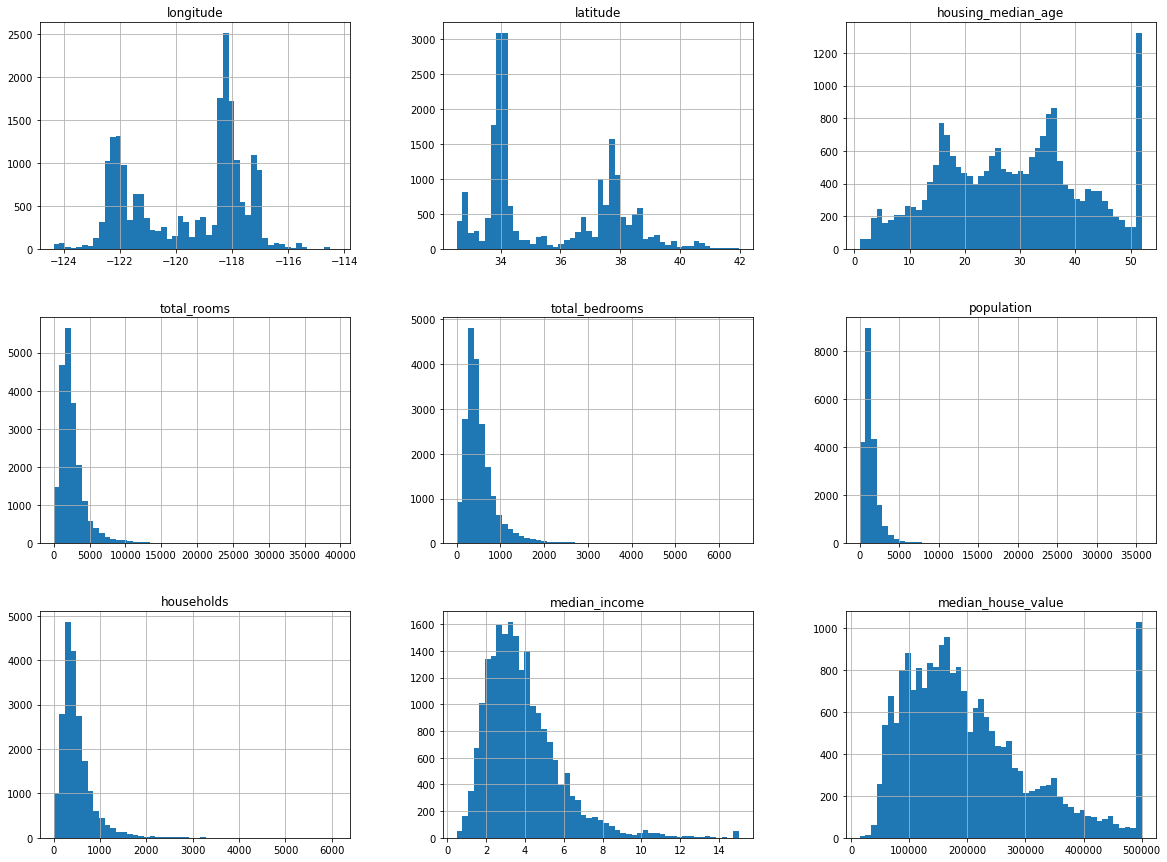

In [153]:
housesDF.hist(bins=50, figsize=(20, 15))
plt.show()

There are a few things to notice here

1. The values follow various distribution(s)
2. They cover a variety of scales
3. Some values (e.g. `median_house_value` and `housing_media_age` have extreme values which probably represent some sort of cut off or binning

The histograms for latitude and longitude are probably hiding some structure, all of the values should fall somewhere on a map of California...

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

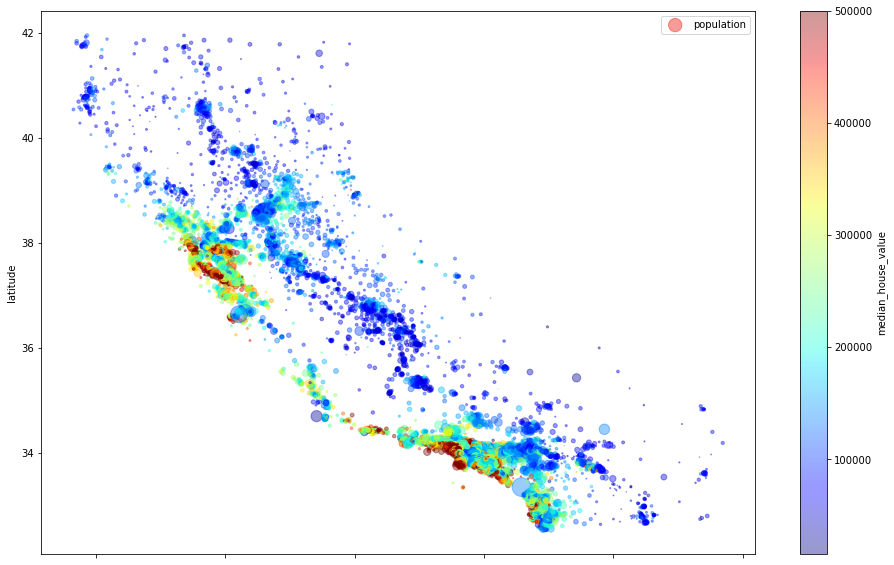

In [154]:
housesDF.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=housesDF['population']/100,
    label='population',
    c='median_house_value',
    cmap=plt.get_cmap("jet"),
    colorbar=True
)

After taking a look at the individual features, the next thing is to look at combinations of features. Often this can help you prepare the dataset so that the algorithms you select have the best chance for success

In [155]:
housesDF.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


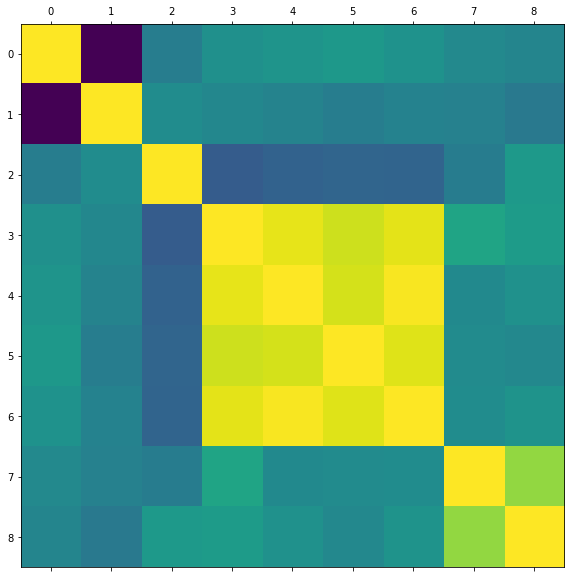

In [156]:
fig, ax = plt.subplots()

ax.matshow(housesDF.corr())

To dig a little deeper, you can look at the `scatter_matrix` which plots the numerical values of features against each other 

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

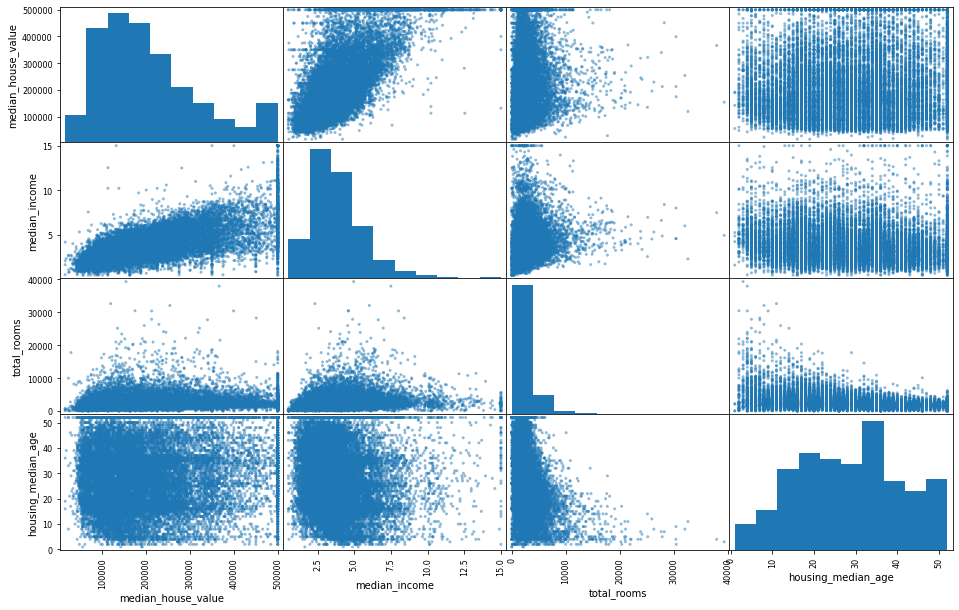

In [157]:
from pandas.plotting import scatter_matrix

attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age'
]
scatter_matrix(housesDF[attributes])

The `median_income` shows strong positive correlation with the `median_house_value`. You can see horizontal lines showing a hard cap of \\$500,000 as well as fainter lines clustered around some other figures (\\$450,000, \\$350,000) etc. These are likely to be artifacts of the way the data was collected or encoded and you should decide what to do with them. For example, it might be worth trying to train your model without the entries valued at \\$500,000 (assuming that the actual values were larger but were encoded as \\$500,000 during data entry).

In [158]:
housesDF.drop(housesDF[housesDF['median_house_value']>=500000].index, inplace=True)
housesDF.reset_index(inplace=True)

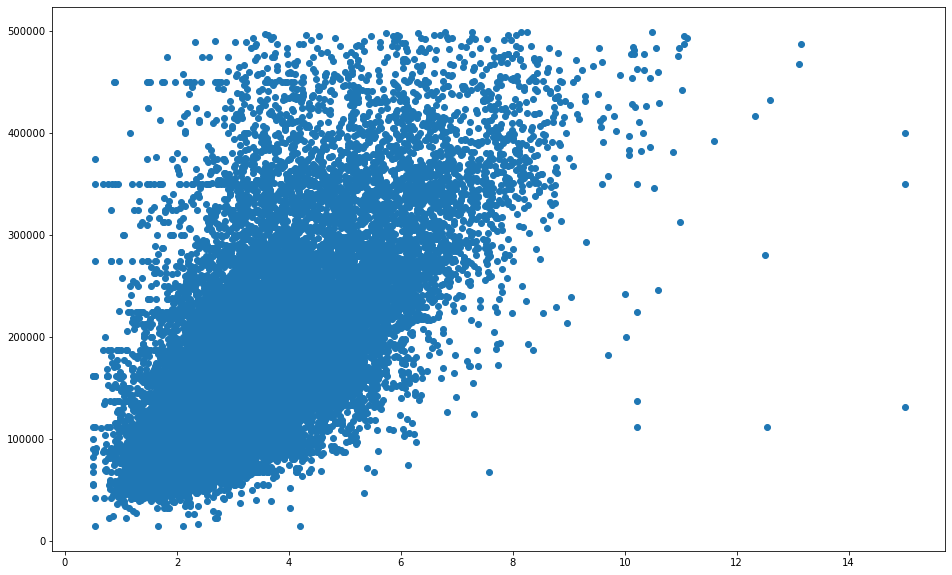

In [159]:
fix, ax = plt.subplots()
ax.scatter(housesDF['median_income'], housesDF['median_house_value'])

It is also useful to look at combinations at attributes. For example, we have the total number of households per district and the total number of bedrooms, but we could combine those to give the number of rooms per household...

In [160]:
housesDF['rooms_per_household'] = housesDF['total_rooms'] / housesDF['households']
housesDF['betrooms_per_room'] = housesDF['total_bedrooms'] / housesDF['total_rooms']
housesDF['population_per_household'] = housesDF['population'] / housesDF['households']

In [161]:
housesDF.corr()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,betrooms_per_room,population_per_household
index,1.000000,-0.093128,0.066202,-0.192083,0.069566,0.038959,0.031631,0.037007,0.080575,0.069689,0.047973,-0.113310,0.006067
longitude,-0.093128,1.000000,-0.924139,-0.101740,0.044346,0.069887,0.100989,0.055745,-0.008992,-0.045733,-0.029497,0.096136,0.002331
latitude,0.066202,-0.924139,1.000000,0.006083,-0.033502,-0.067943,-0.113457,-0.072854,-0.078135,-0.149257,0.121036,-0.126947,0.001915
housing_median_age,-0.192083,-0.101740,0.006083,1.000000,-0.372174,-0.327505,-0.294911,-0.309633,-0.195542,0.065139,-0.180816,0.155581,0.015001
total_rooms,0.069566,0.044346,-0.033502,-0.372174,1.000000,0.934233,0.859642,0.921177,0.224303,0.144988,0.145583,-0.190546,-0.024402
total_bedrooms,0.038959,0.069887,-0.067943,-0.327505,0.934233,1.000000,0.879269,0.979137,0.022125,0.075219,0.014651,0.072821,-0.028130
population,0.031631,0.100989,-0.113457,-0.294911,0.859642,0.879269,1.000000,0.909090,0.042576,0.013592,-0.068886,0.026810,0.070084
households,0.037007,0.055745,-0.072854,-0.309633,0.921177,0.979137,0.909090,1.000000,0.046275,0.095634,-0.076104,0.054012,-0.027117
median_income,0.080575,-0.008992,-0.078135,-0.195542,0.224303,0.022125,0.042576,0.046275,1.000000,0.646719,0.325739,-0.626844,0.026172
median_house_value,0.069689,-0.045733,-0.149257,0.065139,0.144988,0.075219,0.013592,0.095634,0.646719,1.000000,0.111581,-0.220030,-0.021205


To deal with missing values, you can either discard the corresponding data, or replace them with some useful value. Personally, I usually try discarding them first, but if that isn't feasible (throwing away too much valuable data), then scikit-learn has some convenience classes which will help fill in those values.

In [162]:
from sklearn.impute import SimpleImputer

In [163]:
median_imputer = SimpleImputer(strategy='median')

housesDF_num = housesDF.drop('ocean_proximity', axis=1)

median_imputer.fit(housesDF_num)

SimpleImputer(strategy='median')

In [164]:
X = median_imputer.transform(housesDF_num)
type(X)

numpy.ndarray

In [165]:
housesDF_tr = pd.DataFrame(
    X,
    columns=housesDF_num.columns, 
    index=housesDF_num.index
)

For the categorical values, we will use one hot encoding. You can do this explicitly with `pd.get_dummies`, but similar to what we did with the Imputer, using the corresponding sklearn class lets us reuse the transformation conveniently

In [166]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

housesDF_cat = housesDF[['ocean_proximity']]
X = cat_encoder.fit_transform(housesDF_cat)
type(X)

scipy.sparse._csr.csr_matrix

In [167]:
housesDF_cat_tr = pd.DataFrame(
    X.toarray(),
    columns = cat_encoder.categories_[0],
    index = housesDF_cat.index
) 

The same argument about reusing the transformation could be applied to the combined attributes, you could write them as an sklearn transformation so that they become more easy to apply to new data etc. We'll skip it for now, and just apply that transform staticly to the dataframe, but [Aurélien's notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) defines a class tod o this

#### Feature Scaling

Generally, machine learning algorithms want to work with numerical values which share a similar scale. Taking logs etc. can help, but again sklearn also includes some convenience classes, we'll use `StandardScaler` which subtracts the mean and scales to unit variance, we'll also pipeline our transforms together to make them convenient to use

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [169]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

X = num_pipeline.fit_transform(housesDF_num)

In [170]:
housesDF_num_tr = pd.DataFrame(
    X,
    columns=housesDF_num.columns, 
    index=housesDF_num.index
)

In [171]:
housesDF_num_tr

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,betrooms_per_room,population_per_household
0,-1.717094,-1.330014,1.036333,1.009853,-0.797473,-0.974022,-0.978430,-0.978640,2.959952,2.683030,0.707472,-1.204738,-0.050851
1,-1.716927,-1.325029,1.027030,-0.589669,2.052252,1.349320,0.838805,1.661028,2.944799,1.714009,0.382175,-1.042208,-0.092746
2,-1.716760,-1.335000,1.022379,1.889591,-0.528492,-0.828962,-0.826338,-0.845613,2.280068,1.648104,1.276098,-1.506202,-0.027663
3,-1.716593,-1.339986,1.022379,1.889591,-0.616931,-0.721950,-0.772144,-0.736062,1.252220,1.536888,0.198688,-0.536171,-0.051567
4,-1.716426,-1.339986,1.022379,1.889591,-0.455176,-0.614939,-0.766026,-0.631727,0.108107,1.546156,0.401238,-0.754437,-0.086014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19643,1.728943,-0.761637,1.780515,-0.269765,-0.437763,-0.391403,-0.521280,-0.446533,-1.347359,-1.173486,-0.137906,0.172980,-0.050377
19644,1.729110,-0.821466,1.785166,-0.829598,-0.881329,-0.924083,-0.948710,-1.009940,-0.712873,-1.183784,0.328060,0.006726,0.002467
19645,1.729277,-0.826452,1.757259,-0.909574,-0.167866,-0.127441,-0.379677,-0.177871,-1.258410,-1.027258,-0.068098,0.006108,-0.072463
19646,1.729444,-0.876310,1.757259,-0.829598,-0.348409,-0.308172,-0.612186,-0.396974,-1.151951,-1.105521,-0.014039,0.089432,-0.091490


In [172]:
housesDF_tr = housesDF_num_tr.join(housesDF_cat_tr)
housesDF_tr.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,betrooms_per_room,population_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.717094,-1.330014,1.036333,1.009853,-0.797473,-0.974022,-0.978430,-0.978640,2.959952,2.683030,0.707472,-1.204738,-0.050851,0.0,0.0,0.0,1.0,0.0
1,-1.716927,-1.325029,1.027030,-0.589669,2.052252,1.349320,0.838805,1.661028,2.944799,1.714009,0.382175,-1.042208,-0.092746,0.0,0.0,0.0,1.0,0.0
2,-1.716760,-1.335000,1.022379,1.889591,-0.528492,-0.828962,-0.826338,-0.845613,2.280068,1.648104,1.276098,-1.506202,-0.027663,0.0,0.0,0.0,1.0,0.0
3,-1.716593,-1.339986,1.022379,1.889591,-0.616931,-0.721950,-0.772144,-0.736062,1.252220,1.536888,0.198688,-0.536171,-0.051567,0.0,0.0,0.0,1.0,0.0
4,-1.716426,-1.339986,1.022379,1.889591,-0.455176,-0.614939,-0.766026,-0.631727,0.108107,1.546156,0.401238,-0.754437,-0.086014,0.0,0.0,0.0,1.0,0.0


Now that we know how we want to transform the incoming data, we can build a pipeline transformer which will allow us to conveniently apply all of our changes

In [181]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housesDF_num.columns)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housesDF_prepared = full_pipeline.fit_transform(housesDF)

In [183]:
housesDF_prepared

array([[-1.71709396, -1.33001446,  1.03633273, ...,  0.        ,
         1.        ,  0.        ],
       [-1.71692696, -1.32502869,  1.02703046, ...,  0.        ,
         1.        ,  0.        ],
       [-1.71675996, -1.33500023,  1.02237932, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.72927737, -0.82645182,  1.75725903, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.72944437, -0.8763095 ,  1.75725903, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.72961137, -0.83642335,  1.7293522 , ...,  0.        ,
         0.        ,  0.        ]])

## Split the test and training data

Strictly speaking, I think this is the first thing you're supposed to do. The idea is you'll set aside the test data and only look at it when you're ready to evaluate your model(s). I jumped the gun a bit to take a look around the data, but from this point on we'll deal with the training set.

When splitting the training and test set, we want to make sure that both sets are sampled without bias. In our example, we are to assume that `median_income` will be important to our final housing price predictions and we want to make sure that our training set includes data from the full range of incomes. Since `median_income` is an (almost) continuous variable, the idea is to bin the values into categories, then use those categories to sample from.

In [203]:
housesDF['income_cat'] = pd.cut(housesDF['median_income'],
       bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf],
       labels = [1, 2, 3, 4, 5]
)

In [204]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housesDF, housesDF['income_cat']):
    strat_train_set = housesDF.loc[train_idx]
    strat_test_set = housesDF.loc[test_idx]

<AxesSubplot:>

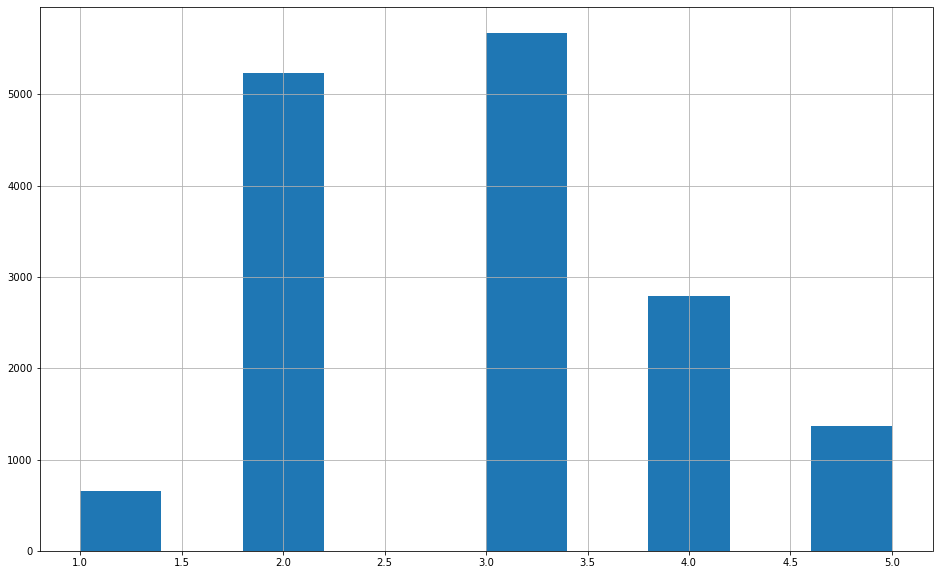

In [205]:
strat_train_set['income_cat'].hist()

So our training set looks like it samples the various income categories well.

In [202]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

trainDF = pd.DataFrame(
    full_pipeline.fit_transform(strat_train_set),
    columns = strat_train_set.columns + strt,
    index = strat_train_set.index
)

ValueError: Shape of passed values is (15718, 18), indices imply (15718, 14)

In [209]:
full_pipeline.

AttributeError: 'ColumnTransformer' object has no attribute 'cat'

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

## Training a model

After all of the hard work of preparing the data, the consistent design of scikit-learn lets us actually train a model very quickly...

In [140]:
from sklearn.linear_model import LinearRegression

housing_labels = strat_train_set['median_house_value']
housing_prepared = strat_train_set.drop('median_house_value', axis=1) 
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

ValueError: could not convert string to float: '<1H OCEAN'

In [33]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.6116458939690558

In [141]:
housing_prepared

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,betrooms_per_room,population_per_household
14445,15077,-116.99,32.81,18.0,10968.0,1521.0,4439.0,1501.0,6.2787,<1H OCEAN,7.307129,0.138676,2.957362
14458,15090,-116.92,32.81,17.0,1312.0,394.0,836.0,337.0,1.6686,<1H OCEAN,3.893175,0.300305,2.480712
12587,13187,-117.70,34.08,10.0,1979.0,454.0,1117.0,389.0,3.7802,INLAND,5.087404,0.229409,2.871465
6490,6790,-118.15,34.10,36.0,3514.0,818.0,2277.0,828.0,3.1211,<1H OCEAN,4.243961,0.232783,2.750000
11984,12583,-121.43,38.52,30.0,3657.0,945.0,2925.0,899.0,1.3927,INLAND,4.067853,0.258409,3.253615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,5132,-118.26,33.98,43.0,762.0,206.0,854.0,188.0,1.2315,<1H OCEAN,4.053191,0.270341,4.542553
6405,6681,-118.09,34.15,52.0,670.0,141.0,268.0,110.0,3.5568,INLAND,6.090909,0.210448,2.436364
13880,14507,-117.21,32.89,14.0,3114.0,773.0,1592.0,776.0,3.3176,NEAR OCEAN,4.012887,0.248234,2.051546
11085,11678,-117.99,33.85,35.0,1661.0,272.0,949.0,276.0,5.2548,<1H OCEAN,6.018116,0.163757,3.438406
